In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from typing import Tuple

* [Modelo para el crecimiento de organismos](#modelo-crecimiento)
* [El modelo lineal](#el-modelo-lineal)
* [El error](#el-error)
* [¿Cómo encontramos los parámetros adecuados?](#como-encontrar-parametros)
    * [Encontrando parámetros adivinando a ojímetro](#encontrar-parametros-adivinando)
    * [Encontrando parámetros de forma explícita](#encontrar-parametros-explicita)
        * [Ejercicio de calentamiento: calcular m_exact y b_exact implementando las formulas anteriores en numpy](#ejercicio-de-calentamiento)
    * [Encontrando parámetros vía descenso de gradiente](#encontrar-parametros-descenso-gradiente)
        * [Calculando derivadas a mano](#calculando-derivadas-a-mano)
        * [Calculando derivadas automáticamente](#calculando-derivadas-automaticamente)
        * [Visualizando el gradiente](#visualizando-el-gradiente)
        * [Implementación de descenso de gradiente](#implementacion-descenso-gradiente)
    * [Encontrando parámetros vía descenso de gradiente estocástico](#encontrar-parametros-descenso-gradiente-estocastico)
        * [Comparación de descenso de gradiente vs descenso de gradiente estocástico](#comparacion)
* [El modelo cuadrático](#el-modelo-cuadratico)
    * [Ejercicio 0: programar la función predictora y la función de error para este modelo](#ejercicio-0)
    * [Ejercicio 1: encontrar parámetros a ojímetro y pintarlos](#ejercicio-1)
    * [Ejercicio 2: programar una función que encuentre el gradiente para los parámetros de este modelo](#ejercicio-2)
    * [Ejercicio 3: programar un algoritmo de descenso de gradiente para este caso](#ejercicio-3)
    * [Ejercicio 4: visualizar el resultado del descenso de gradiente](#ejercicio-4)
    * [Ejercicio 5: ¿El error del modelo cuadrático es menor que el error del modelo lineal?](#ejercicio-5)
    * [Ejercicio 6: ¿Qué modelo usarías: el cuadrático o el lineal?](#ejercicio-6)

<span id='modelo-crecimiento'></id>
### Modelo para el crecimiento de organismos

Estamos en un [laboratorio secreto en las profundidades de la Rodina](https://www.youtube.com/watch?v=EFqjDXy9s5A) estudiando el crecimiento de los organismos que provienen de una espora misteriosa.

Necesitamos un modelo matemático que nos permita predecir la [velocidad de crecimiento del organismo](https://www.cs.montana.edu/webworks/projects/stevesbook/contents/chapters/chapter002/section002/black/page001.html) en términos de a temperatura. Hemos llevado a cabo los primeros experimentos con resultados en `growth_rate_vs_temperature.csv`:

In [2]:
df = pd.read_csv('growth_rate_vs_temperature.csv')
df

,specific_growth_rate,temperature
0,0.670221,2.179303
1,0.677414,2.321640
2,0.686173,2.482748
3,0.709172,2.925272
4,0.718978,3.261580
5,0.726890,3.511283
6,0.740944,4.079765
7,0.750132,5.096700
8,0.746448,5.413272


Lo primero es visualizar los datos para hacernos una idea:

<IPython.core.display.Javascript object>


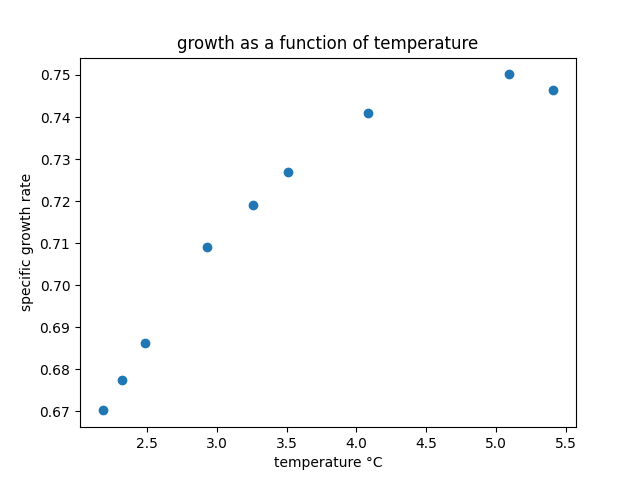

In [3]:
def get_xy_limits(xs, ys):
    def get_lims(array_like):
        min_max = np.array([np.min(array_like), np.max(array_like)])
        err = (min_max[1] - min_max[0]) / 10
        return min_max + np.array([-err, err])
    return get_lims(xs), get_lims(ys)

f, ax = plt.subplots()
ax.set_title("growth as a function of temperature")
ax.set_ylabel('specific growth rate')
ax.set_xlabel('temperature °C')
ax.plot(df['temperature'], df['specific_growth_rate'], 'o')

Nuestro supervisor nos ha pedido que empecemos usando un ajuste lineal con error de mínimos cuadrados.

<span id='el-modelo-lineal'></id>
### El modelo lineal

El modelo lineal tiene 2 parámetros a ajustar:

* $m$, la pendiente de la recta de regresión
* $b$, la intersección con el eje y en x=0 de la recta de regresión

Con estos parámetros, el modelo hará una predicción del crecimiento del organismo dada una temperatura:

$$
rate = m \cdot temperature + b
$$

El espacio de parámetros del modelo es de 2 dimensiones: cada punto ($m$, $b$) en este espacio corresponde a un modelo distinto.

In [4]:
def predict_rate(m, b, temperature):
    return m * temperature + b


<span id='el-error'></id>
### El error

El error de una predicción es la desviación del valor real del rate cuando lo comparamos con el valor de la predicción del modelo.



El error a minimizar es el [error de mínimos cuadrados](https://en.wikipedia.org/wiki/Least_squares), es decir, queremos encontrar los parámetros $m$ y $b$ para minimizar la suma de estos errores en todas las observaciones:

$$
loss = \sum_{i=1}^{n} \left(rate_i - \big(m \cdot temperature_i + b \right) \big) ^ 2
$$

In [5]:
def error(m, b, observed_temperature, observed_rate) -> float:
    predicted_rate = predict_rate(m, b, observed_temperature)
    return (observed_rate - predicted_rate) ** 2

Esta función nos permite asociar a cada modelo un [loss](https://en.wikipedia.org/wiki/Loss_function) sumando los errores para todo el conjunto de puntos:

In [6]:
def loss(m, b, observed_temperatures, observed_rates) -> float:
    predicted_rates = predict_rate(m, b, observed_temperatures)
    errors = (observed_rates - predicted_rates) ** 2
    return np.sum(errors)

Como nuestro espacio de parámetros solo tiene 2 dimensiones es fácil visualizar la superficie de error, intuitivamente podemos ver que los modelos cerca de $m \approx 0$ y $b \approx 0.5$ tienen un error bajo, y el error crece a medida que nos alejamos de esa región:

<IPython.core.display.Javascript object>


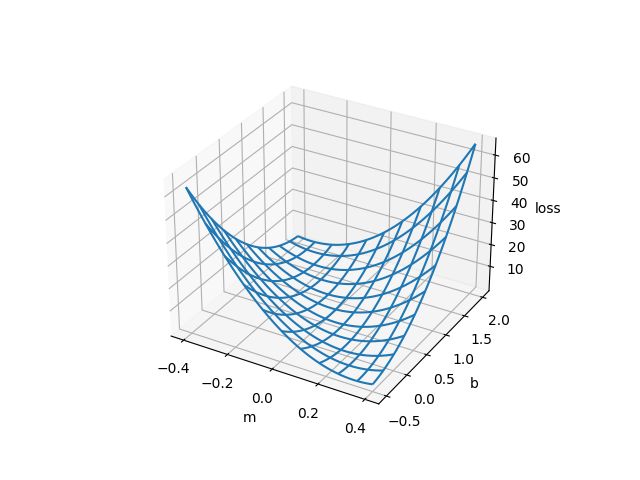

In [7]:
ms = np.linspace(-0.4, 0.4)
bs = np.linspace(-0.5, 2)
mv, bv = np.meshgrid(ms, bs)
losses = np.zeros(shape=mv.shape)

for i in range(losses.shape[0]):
    for j in range(losses.shape[1]):
        losses[i, j] = loss(mv[i, j], bv[i, j], df['temperature'], df['specific_growth_rate'])
        
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_ylabel('b')
ax.set_xlabel('m')
ax.set_zlabel('loss')
wire = ax.plot_wireframe(mv, bv, losses, rstride=5, cstride=5)


<span id='como-encontrar-parametros'></id>
## ¿Cómo encontramos los parámetros adecuados?


<span id='encontrar-parametros-adivinando'></id>
### Encontrando parámetros adivinando a ojímetro

Nadie en el laboratorio sabe mucho de matemáticas, así que hemos decidido que cada uno se inventará unos parámetros; el que tenga menor error ganará una botella de vodka.

In [8]:
guessed_values = pd.DataFrame({
    'm': [0.0, 0.035, -0.1],
    'b': [0.68, 0.6, 1],
    'label': ['Boris', 'Vova', 'Alyosha']
})
guessed_values['error'] = guessed_values.apply(lambda row: loss(row['m'], row['b'], df['temperature'], df['specific_growth_rate']), axis=1)
guessed_values

,m,b,label,error
0,0.000,0.68,Boris,0.017757
1,0.035,0.60,Vova,0.002789
2,-0.100,1.00,Alyosha,0.205600


Al visualizar las distintas propuestas el ojo confirma lo que dice el error: la solución de Vova parece la mejor, pero seguro que se puede mejorar.

<IPython.core.display.Javascript object>


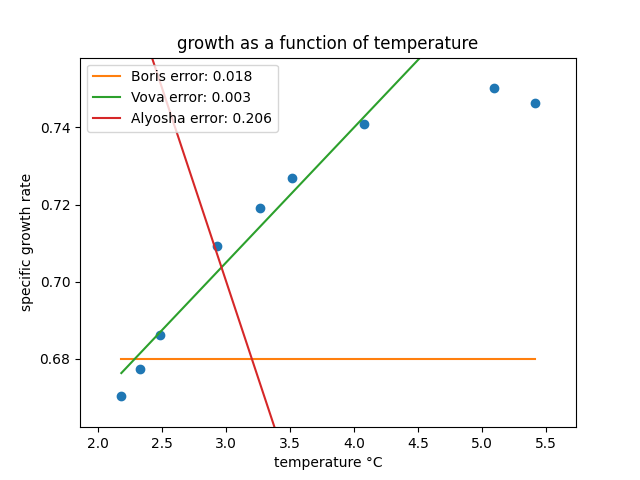

In [9]:
xlim, ylim = get_xy_limits(df['temperature'], df['specific_growth_rate'])

f, ax = plt.subplots(1)
ax.set_title("growth as a function of temperature")
ax.set_ylabel('specific growth rate')
ax.set_xlabel('temperature °C')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.plot(df['temperature'], df['specific_growth_rate'], 'o')

for row in guessed_values.itertuples():
    label = "{0} error: {1:.3f}".format(row.label, row.error)
    predicted_rate = predict_rate(row.m, row.b, df['temperature'])
    ax.plot(df['temperature'], predicted_rate, label=label)
    

plt.legend(loc="upper left")



<span id='encontrar-parametros-explicita'></id>
### Encontrando parámetros de forma explícita

En este caso, por fortuna, existe una solución explícita sencilla para calcular los parámetros $m$ y $b$ del modelo.

Alguien que sabe más matemáticas que nosotros ha encontrado las fórmulas que [determinan los parámetros m y b de una regresión lineal simple](https://en.wikipedia.org/wiki/Simple_linear_regression#Fitting_the_regression_line) en términos de los valores de nuestros puntos de datos $(x_i, y_i)$:

$$
\bar{x} = \frac{\sum_{i=1}^n x_i} {n}
$$

$$
\bar{y} = \frac{\sum_{i=1}^n y_i} {n}
$$

$$
$$

$$
m = \frac{ \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) }{ \sum_{i=1}^n (x_i - \bar{x})^2 }
$$

$$
b = \bar{y} - m \cdot \bar{x}
$$

<span id='ejercicio-de-calentamiento'></id>
#### Ejercicio de calentamiento: calcular m_exact y b_exact implementando las formulas anteriores en numpy

In [10]:
temperature_mean = np.mean(df['temperature'])
## ... etcetera

# Valores exactos que he calculado usando las fórmulas:
m_exact = 0.024 
b_exact = 0.631

Si pintamos la solución vemos que visualmente parece una buena aproximación, mejor que la de Vova:

<IPython.core.display.Javascript object>


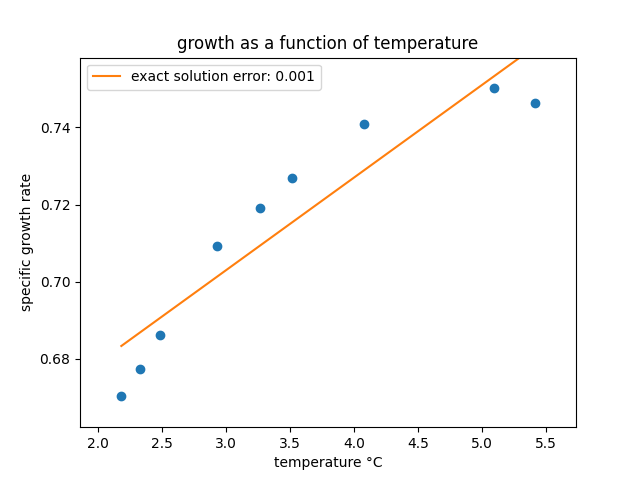

In [11]:
xlim, ylim = get_xy_limits(df['temperature'], df['specific_growth_rate'])

f, ax = plt.subplots()
ax.set_title("growth as a function of temperature")
ax.set_ylabel('specific growth rate')
ax.set_xlabel('temperature °C')
ax.plot(df['temperature'], df['specific_growth_rate'], 'o')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

predicted_rate = predict_rate(m_exact, b_exact, df['temperature'])

label = "exact solution error: {0:.3f}".format(loss(m_exact, b_exact, df['temperature'], df['specific_growth_rate']))
ax.plot(df['temperature'], predicted_rate, label=label)
plt.legend(loc="upper left")

<span id='encontrar-parametros-descenso-gradiente'></id>
### Encontrando parámetros vía descenso de gradiente

No siempre existe una solución cerrada conveniente como en este caso.

Encontrar el mejor modelo es un problema de minimización donde nuestra función de error es diferenciable: podemos usar [descenso de gradiente](https://en.wikipedia.org/wiki/Gradient_descent) en estos casos.

Para aplicar el descenso de gradiente sólo tenemos que ser capaces de calcular la derivada de nuestra función de error, que en general es mucho más fácil que determinar una solución explícita como hemos hecho arriba.

<span id='calculando-derivadas-a-mano'></id>
#### Calculando derivadas a mano

Vamos a calcular las derivadas parciales con respecto a $m$ y a $b$, si hemos olvidado hacer derivadas podemos recurrir a programas de diferenciación simbólica como [maxima](https://en.wikipedia.org/wiki/Maxima_(software)):

$$
\nabla Loss(m, b) = \frac{\partial Loss}{\partial m}, \frac{\partial Loss}{\partial b}
$$

$$
\frac{\partial}{\partial m} \sum_{i=1}^{n} \left(rate_i - \big(m \cdot temperature_i + b \right) \big) ^ 2 = \sum_{i=1}^{n} -2 \cdot temperature_i  \cdot (- m \cdot temperature_i + rate_i - b)
$$

$$
\frac{\partial}{\partial b} \sum_{i=1}^{n} \left(rate_i - \big(m \cdot temperature_i + b \right) \big) ^ 2 = \sum_{i=1}^{n} -2 \cdot (- m  \cdot temperature_i + rate_i - b)
$$

Ahora podemos definir una función `loss_gradient` que devuelva el gradiente como una tupla de $\frac{\partial Loss} {\partial m}$,  $\frac{\partial Loss} {\partial b}$ :

In [12]:
def loss(m, b, observed_temperatures, observed_rates) -> float:
    predicted_rates = predict_rate(m, b, observed_temperatures)
    errors = (observed_rates - predicted_rates) ** 2
    return np.sum(errors)

def loss_gradient(m, b, observed_temperatures, observed_rates) -> Tuple[float, float]:
    dloss_dbs = -2 * (-m * observed_temperatures + observed_rates - b)
    dloss_db = dloss_dbs.sum()
    
    dloss_dms = -2 * observed_temperatures * (-m * observed_temperatures + observed_rates - b)
    dloss_dm = dloss_dms.sum()
    
    return dloss_dm, dloss_db
    

<span id='calculando-derivadas-automaticamente'></id>
#### Calculando derivadas automáticamente

Calcular derivadas a mano puede ser tedioso y dado a error, como hemos visto arriba.

La [diferenciación automática](https://en.wikipedia.org/wiki/Automatic_differentiation) al rescate: las potentísimas librerías modernas de autograd pueden calcular directamente la derivada de una loss function y nos ahorran todas esas matemáticas, vamos a usar [jax](https://jax.readthedocs.io/en/latest/index.html):

In [13]:
import jax
import jax.numpy as jnp

def jax_loss(m, b, observed_temperatures, observed_rates):
    predicted_rates = predict_rate(m, b, observed_temperatures)
    errors = (observed_rates - predicted_rates) ** 2
    return jnp.sum(errors)

Una vez expresada la función de loss en términos que jax entiende, jax se ocupa de calcular el gradiente de esta función automáticamente:

In [14]:
## magia: le decimos a jax que diferencie la función con respecto al primer y segundo argumento,
## es decir, con respecto a m y b
jax_loss_gradient = jax.grad(jax_loss, argnums=(0, 1))

Vamos a comprobar rápidamente que el gradiente que calcula jax coincide con el gradiente que hemos calculado a mano:

In [15]:
##sanity check
m = 0.5
b = 0.1

observed_temperatures = np.array(df['temperature'])
observed_rates = np.array(df['specific_growth_rate'])


handmade_result = loss_gradient(m, b, observed_temperatures, observed_rates)
print('loss_gradient: dloss_dm = {0:.3f} dloss_db = {1:.3f}'.format(*handmade_result))

jax_result = jax_loss_gradient(m, b, observed_temperatures, observed_rates)
print('jax_loss_gradient: dloss_dm = {0:.3f} dloss_db = {1:.3f}'.format(*jax_result))

loss_gradient: dloss_dm = 80.815 dloss_db = 20.219
jax_loss_gradient: dloss_dm = 80.815 dloss_db = 20.219


<span id='visualizando-el-gradiente'></id>
#### Visualizando el gradiente

Vamos a pintar el espacio de parámetros en 2d y visualizamos la función de loss con un heatmap, valores más pequeños del error corresponen a colores más fríos.

Podemos visualizar el gradiente calculándolo para cada punto en una cuadrícula de 20 x 20: si pintamos una flecha en la dirección del gradiente negativo en estos puntos vemos que pasa lo esperado:
* el gradiente negativo apunta en la dirección de hace que decrezca la función de error
* la magnitud del gradiente negativo se hace más pequeña a medida que nos aproximamos al mínimo de la función de error

La intuición detrás del método de descenso de gradiente es muy sencilla: para encontrar el mínimo de la función, simplemente vamos tomando pasos pequeños en el espacio de parámetros siguiendo la dirección del gradiente negativo. 

Según dónde empezemos el camino llegaremos antes o después a un mínimo, pero llegaremos.

<IPython.core.display.Javascript object>


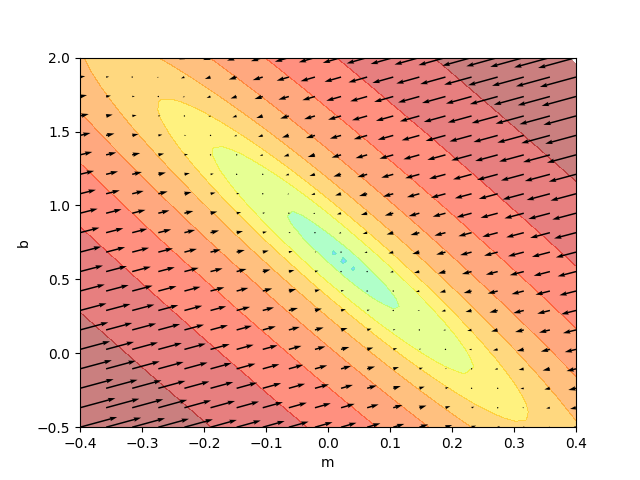

In [16]:
f, ax = plt.subplots()

m_min, m_max = -0.4, 0.4
b_min, b_max = -0.5, 2

def draw_heatmap(ax):
    ms = np.linspace(m_min, m_max)
    bs = np.linspace(b_min, b_max)
    mv, bv = np.meshgrid(ms, bs)
    losses = np.zeros(shape=mv.shape)

    for i in range(losses.shape[0]):
        for j in range(losses.shape[1]):
            losses[i, j] = loss(mv[i, j], bv[i, j], np.array(df['temperature']), np.array(df['specific_growth_rate']))


    ax.set_ylabel('b')
    ax.set_xlabel('m')
    ax.contourf(mv, bv, losses, 
                levels = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 4, 8, 16, 32, 64], norm='log', cmap='jet', alpha=0.5)


def draw_gradients(ax):
    # calculate gradients at points in a grid
    ms = np.linspace(m_min, m_max, 20)
    bs = np.linspace(b_min, b_max, 20)
    mv, bv = np.meshgrid(ms, bs)
    dms = np.zeros(shape=mv.shape)
    dbs = np.zeros(shape=mv.shape)

    for i in range(dms.shape[0]):
        for j in range(dms.shape[1]):
            dms[i, j], dbs[i,j] = jax_loss_gradient(mv[i, j], bv[i, j], 
                                                    np.array(df['temperature']), 
                                                    np.array(df['specific_growth_rate']))

    quiver = ax.quiver(mv, bv, -dms, -dbs)
    
draw_heatmap(ax)
draw_gradients(ax)

<span id='implementacion-descenso-gradiente'></id>
#### Implementación de descenso de gradiente

Siguiendo la notación del artículo de [descenso de gradiente](https://en.wikipedia.org/wiki/Gradient_descent), a cada paso del algoritmo actualizaremos los parámetros $m$ y $b$ de la siguiente manera:

$$
\mathbf{a}_{n+1} = \mathbf{a}_n-\gamma\nabla Loss(\mathbf{a}_n)
$$

Para la componente $m$

$$
m_{n+1} = m_n  - \gamma \cdot \frac{\partial Loss} {\partial m}
$$

$$
m_{n+1} = m_n  - \gamma \cdot \big( \sum_{i=1}^{k} -2 \cdot temperature_i  \cdot (- m_n \cdot temperature_i + rate_i - b_n) \big)
$$

Y para $b$:

$$
b_{n+1} = b_n  - \gamma \cdot \frac{\partial Loss} {\partial b}
$$

$$
b_{n+1} = b_n  - \gamma \cdot \big( \sum_{i=1}^{k} -2 \cdot (- m_n \cdot temperature_i + rate_i - b_n) \big)
$$

Podemos implementar directamente el algoritmo de descenso de gradiente que hemos leído en wikipedia:

In [17]:
def gradient_descent(
    observed_temperatures, 
    observed_rates, 
    m0, 
    b0, 
    step_num, 
    step_size) -> Tuple[float, float, pd.DataFrame]:
    
    """
    Perform step_num gradient descent steps, starting at (m0, b0).
    
    Parameters
    ----------
    observed_temperatures : array
    observed_rates : array
    m0 : float
        initial value for m
    b0 : float
        initial value for b
    step_num : int
        number of gradient descent steps to perform
    step_size : float
    
    Returns
    -------
    m : float
      The final value of m
    b : float
      The final value of b
    trajectory:
      A dataframe containing rows corresponding to intermediate values. Useful for visualization
    
    Notes
    -----
    The trajectory is returned as a dataframe, each row corresponds to a gradient descent step.
    Each descent step has the following columns:
    
    m: value of m at the beginning of the step
    b: value of b at the beginning of the step
    loss: loss value at (m, b)
    dloss_dm: partial derivative of loss with respect to m at (m, b)
    dloss_db: partial derivative of loss with respect to b at (m, b)
    """
    rows = []
    
    m = m0
    b = b0
    
    for i in range(step_num):
        loss_val = loss(m, b, observed_temperatures, observed_rates)
        dloss_dm, dloss_db = loss_gradient(m, b, observed_temperatures, observed_rates)
        
        # keep a row every 200 steps
        if i % 200 == 0:
            row = dict(
                m = m,
                b = b,
                loss=loss_val,
                dloss_dm=dloss_dm,
                dloss_db = dloss_db)
            rows.append(row)
        
        m -= step_size * dloss_dm
        b -= step_size * dloss_db
        
    return m, b, pd.DataFrame(rows)

observed_temperatures = np.array(df['temperature'])
observed_rates = np.array(df['specific_growth_rate'])

m, b, descent_trajectory = gradient_descent(observed_temperatures, observed_rates, 0.0, 0.0, 5000, 0.001)

In [18]:
def plot_gradient_descent_solution_lines(ax, descent_trajectory):
    xlim, ylim = get_xy_limits(df['temperature'], df['specific_growth_rate'])
    
    ax.set_ylabel('specific growth rate')
    ax.set_xlabel('temperature °C')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax.plot(df['temperature'], df['specific_growth_rate'], 'o')

    for i, row in enumerate(descent_trajectory.itertuples()):
        alpha = 0.2 + 0.8 *(i / len(descent_trajectory))
        predicted_rate = predict_rate(row.m, row.b, df['temperature'])
        ax.plot(df['temperature'], predicted_rate, 'r', alpha=alpha)
        
def plot_gradient_descent_solution_trajectory(ax, descent_trajectory):
    draw_heatmap(ax)

    for i, row in enumerate(descent_trajectory.itertuples()):
        alpha = 0.1 + 0.5 *(i / len(descent_trajectory))
        
        ax.plot(row.m, row.b, 'o', alpha=alpha, color="black")
    

Visualicemos las soluciones que va encontrando el descenso de gradiente: vemos que van convergiendo a la solución exacta (en verde) a medida que tomamos más pasos:

<IPython.core.display.Javascript object>


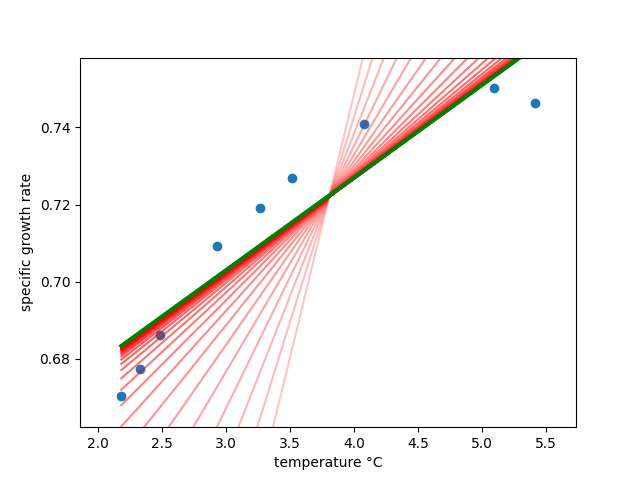

In [19]:
f, ax = plt.subplots(1, 1)
plot_gradient_descent_solution_lines(ax, descent_trajectory)

predicted_rate = predict_rate(m_exact, b_exact, observed_temperatures)
ax.plot(observed_temperatures, predicted_rate, "g", linewidth=3.0)
    

Podemos visualizar la trayectoria también en el espacio de parámetros ($m$, $b$):

<IPython.core.display.Javascript object>


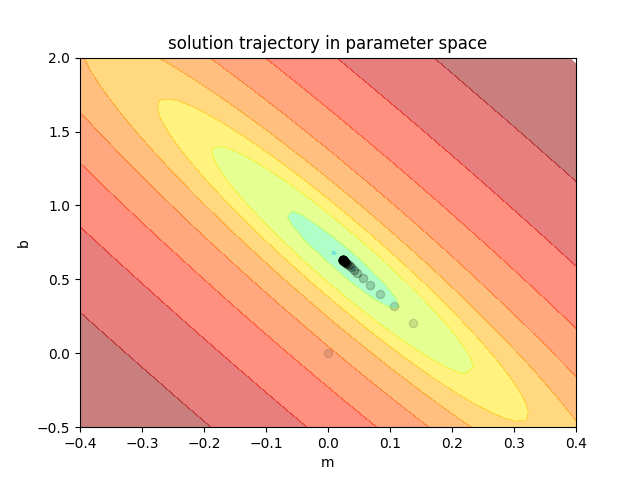

Text(0.5, 1.0, 'solution trajectory in parameter space')

In [20]:
f, ax = plt.subplots()
plot_gradient_descent_solution_trajectory(ax, descent_trajectory)
ax.set_title("solution trajectory in parameter space")

<span id='encontrar-parametros-descenso-gradiente-estocastico'></id>
### Encontrando parámetros vía descenso de gradiente estocástico

En este caso el conjunto de datos es muy pequeño así que podemos calcular directamente el gradiente de la función de error en cada iteración.

Hay muchos problemas reales donde los conjuntos de datos son mucho más grandes. Igual no caben en memoria todos al mismo tiempo, y calcular el gradiente exacto en cada iteración sería muy lento.

En estos casos podemos recurrir al [descenso de gradiente estocástico](): en vez de calcular el gradiente exacto en cada paso de la iteración calculamos una aproximación inexacta al fijarnos solo en un subconjunto aleatorio de los datos.

In [21]:
def get_minibatch(minibatch_size, observed_temperatures, observed_rates) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return a random minibatch of temperatures and rates
    
    Parameters
    ----------
    minibatch_size : int
        number of observations to include in a minibatch
    observed_temperatures : array
    observed_rates : array
    
    Returns
    -------
    temperature_minibatch : np.ndarray
    rate_minibatch : np.ndarray
    
    """
    assert observed_temperatures.shape[0] == observed_rates.shape[0]
    idxs = np.arange(observed_temperatures.shape[0])
    np.random.shuffle(idxs)
    batch_idxs = idxs[:minibatch_size]
    return observed_temperatures[batch_idxs], observed_rates[batch_idxs]
    

def stochastic_gradient_descent(
    observed_temperatures, 
    observed_rates, 
    m0, 
    b0, 
    step_num, 
    step_size,
    minibatch_size) -> Tuple[float, float, pd.DataFrame]:
    
    """
    Perform step_num stochastic gradient descent steps, starting at (m0, b0).
    
    Parameters
    ----------
    observed_temperatures : array
    observed_rates : array
    m0 : float
        initial value for m
    b0 : float
        initial value for b
    step_num : int
        number of gradient descent steps to perform
    step_size : float
    minibatch_size : int
        number of observations to include in a random minibatch
    
    Returns
    -------
    m : float
      The final value of m
    b : float
      The final value of b
    trajectory:
      A dataframe containing rows corresponding to intermediate values. Useful for visualization
    
    """
    rows = []
    
    m = m0
    b = b0
    
    for i in range(step_num):
        temperatures_batch, rates_batch = get_minibatch(minibatch_size, observed_temperatures, observed_rates)
        loss_val = loss(m, b, temperatures_batch, rates_batch)
        dloss_dm, dloss_db = loss_gradient(m, b, temperatures_batch, rates_batch)
        
        if i % 400 == 0:
            row = dict(
                m = m,
                b = b,
                loss=loss_val,
                dloss_dm=dloss_dm,
                dloss_db = dloss_db)
            rows.append(row)
        
        m -= step_size * dloss_dm
        b -= step_size * dloss_db
        
    return m, b, pd.DataFrame(rows)

observed_temperatures = np.array(df['temperature'])
observed_rates = np.array(df['specific_growth_rate'])

m, b, sgd_trajectory = stochastic_gradient_descent(observed_temperatures, observed_rates, 0.0, 0.0, 10000, 0.001, 3)

<span id='comparacion'></id>
#### Comparación de descenso de gradiente vs descenso de gradiente estocástico

Si comparamos las trayectorias de solución veremos que el descenso de gradiente estocástico converge a la misma solución que el descenso de gradiente estándar, pero de forma ruidosa ya que utiliza subconjuntos de datos aleatorios en cada paso de la iteración:

<IPython.core.display.Javascript object>


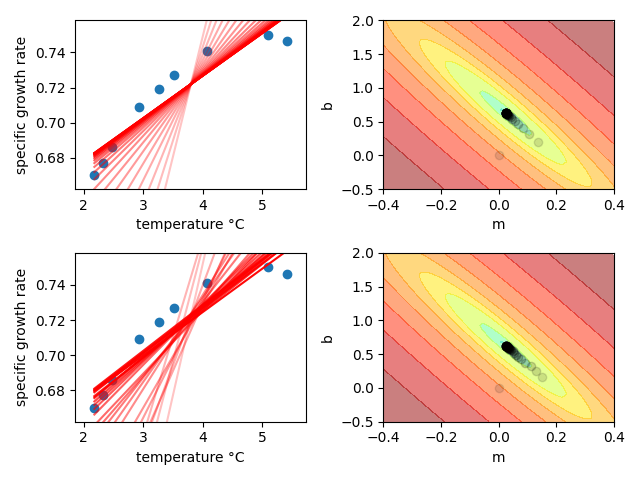

In [22]:
f, ((a, b), (c, d))  = plt.subplots(2, 2)

plot_gradient_descent_solution_lines(a, descent_trajectory)
plot_gradient_descent_solution_trajectory(b, descent_trajectory)

plot_gradient_descent_solution_lines(c, sgd_trajectory)
plot_gradient_descent_solution_trajectory(d, sgd_trajectory)

plt.tight_layout()

<span id='el-modelo-cuadratico'></id>
### El modelo cuadrático

Uno de nuestros supervisores sospecha que igual un modelo con más parámetros que el modelo lineal es más apropiado: propone usar un modelo cuadrático con 3 parámetros:

* $a$, el coeficiente del término cuadrático
* $b$, el coeficiente del término lineal
* $c$, el término constante

Con estos parámetros, el modelo hará una predicción del crecimiento del organismo dada una temperatura de esta forma:

$$
rate = a \cdot temperature ^ 2 + b \cdot temperature + c
$$

Vamos a inspirarnos en el procedimiento seguido para el modelo lineal; podemos definir funciones auxiliares para este modelo de la misma forma que hemos hecho para el modelo lineal, eg.

<span id='ejercicio-0'></id>
### Ejercicio 0: programar la función predictora y la función de error para este modelo

In [23]:
def quad_predict_rate(a, b, c, temperature) -> float:
    """
    TODO
    """
    pass

def quad_error(a, b, c, temperature, observed_rate) -> float:
    """
    TODO
    """
    pass

<span id='ejercicio-1'></id>
### Ejercicio 1: encontrar parámetros a ojímetro y pintarlos

Igual que hemos hecho antes: ¿puedes encontrar parámetros $a$ $b$ y $c$ a ojo para que el modelo dé un ajuste razonable a los puntos? Píntalo con matplotlib.

<span id='ejercicio-2'></id>
### Ejercicio 2: programar una función que encuentre el gradiente para los parámetros de este modelo

Podemos calcular las derivadas a mano de forma simbólica, o podemos definir una función de loss total en términos de primitivas de `jax` y usar `jax.grad` para calcular el gradiente automáticamente.

In [24]:
def quad_error_gradient(a, b, c, observed_temperatures, observed_rates) -> Tuple[float, float, float]:
    """
    TODO
    """
    pass

<span id='ejercicio-3'></id>
### Ejercicio 3: programar un algoritmo de descenso de gradiente para este caso

Una vez tengas la función que calcula el gradiente debería ser muy fácil adaptar el algoritmo de descenso de gradiente que hemos usado para el modelo lineal a este caso.

<span id='ejercicio-4'></id>
### Ejercicio 4: visualizar el resultado del descenso de gradiente 

Será fácil generar un análogo de la función `plot_gradient_descent_solution_lines` para visualizar las soluciones.

Noestro espacio de parámetros para el modelo cuadrático es tridimensional, igual podemos experimentar con un análogo de `plot_gradient_descent_solution_trajectory` en 3 dimensiones.

¿Tu algoritmo de descenso de gradiente ha conseguido encontrar parámetros buenos?

<span id='ejercicio-5'></id>
### Ejercicio 5: ¿El error del modelo cuadrático es menor que el error del modelo lineal?

<span id='ejercicio-6'></id>
### Ejercicio 6: ¿Qué modelo usarías: el cuadrático o el lineal? ¿Otro?

Esta pregunta es central y por desgracia no es tan fácil como escoger el modelo con menos error, eg. ver [overfitting](). Razona la respuesta.